In [1]:
import string
from pathlib import Path

import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from ak_diseq.data import load_rgi
from ak_diseq.glacierData import glacierData
from ak_diseq.utils import hist2, weighted_quantile

plt.style.use('default')

In [2]:
gd = glacierData()
gd.calc_response_time()
gd.calc_linear_feq()
d = gd.rgi
d = gpd.GeoDataFrame(d, geometry='geometry')

In [3]:
rgi = load_rgi()

In [4]:
area = rgi.sort_values(by='Area', ascending=False)['Area']
print(f"Total Area: {rgi.Area.sum()} (N={len(area)})")
print("Top 10:", area[:10].sum())
print(f"All but top 10: {area[10:].sum()} (N={len(area)-10})")
print("Percent: ", area[:10].sum()/area[10:].sum())



print('How much glacier area do we exclude?:')
print(rgi['Area'].sum() - d['Area'].sum())
print('How much of that is from glaciers <1km2?')
print(rgi.loc[rgi.Area <= 1]['Area'].sum())

print('So the proportion excluded is:')
print(rgi.loc[rgi.Area <= 1]['Area'].sum()/rgi.Area.sum())
print(d['Area'].sum()/rgi.Area.sum())

rgi.loc[(rgi.Area >= 1) & (rgi.Zmax - rgi.Zmin <= 250)]['Area'].sum()
d.Area.max()

Total Area: 86725.053 (N=27108)
Top 10: 16217.366
All but top 10: 70507.68700000002 (N=27098)
Percent:  0.23000848120290765
How much glacier area do we exclude?:
20585.926999999996
How much of that is from glaciers <1km2?
6376.386
So the proportion excluded is:
0.07352415224237453
0.7626299865161225


3362.656

In [5]:
gnames = ['Columbia Glacier',
          'Wolverine Glacier',
          'Gulkana Glacier',
          'East Yakutat Glacier',
          'Eklutna Glacier',
          'Exit Glacier',
          'Kahiltna Glacier',
          'Lemon Creek Glacier',
          'Mendenhall Glacier',
          'McCall Glacier',
          'Black Rapids Glacier']
mb_locs = rgi.loc[rgi.Name.isin(gnames), ['Name', 'CenLon', 'CenLat']].drop_duplicates()
mb_locs.loc[mb_locs.Name == 'McCall Glacier', 'CenLat'] = 69

mb_locs

,Name,CenLon,CenLat
36,Black Rapids Glacier,-146.528168,63.469173
569,Gulkana Glacier,-145.427000,63.281000
708,Mendenhall Glacier,-134.478000,58.519000
1103,Lemon Creek Glacier,-134.349000,58.380000
2227,McCall Glacier,-143.847626,69.000000
8984,Eklutna Glacier,-148.988000,61.209000
9157,Wolverine Glacier,-148.908000,60.412000
10684,Columbia Glacier,-146.888000,61.299000
12640,East Yakutat Glacier,-138.651000,59.562000
18082,Exit Glacier,-149.741000,60.156000


<class 'matplotlib.colors.ListedColormap'>
[Text(0, 0.0, ''), Text(0, 250.0, '250'), Text(0, 500.0, '500'), Text(0, 750.0, '750'), Text(0, 1000.0, '1000'), Text(0, 1250.0, '1250'), Text(0, 1500.0, '1500'), Text(0, 1750.0, '1750')]
[Text(0, 0.0, ''), Text(0, 1000.0, '1000'), Text(0, 2000.0, '2000'), Text(0, 3000.0, '3000'), Text(0, 4000.0, '4000'), Text(0, 5000.0, '5000'), Text(0, 6000.0, '6000'), Text(0, 7000.0, '7000')]


/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_96609/965497104.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(labels)
/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_96609/965497104.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(labels)


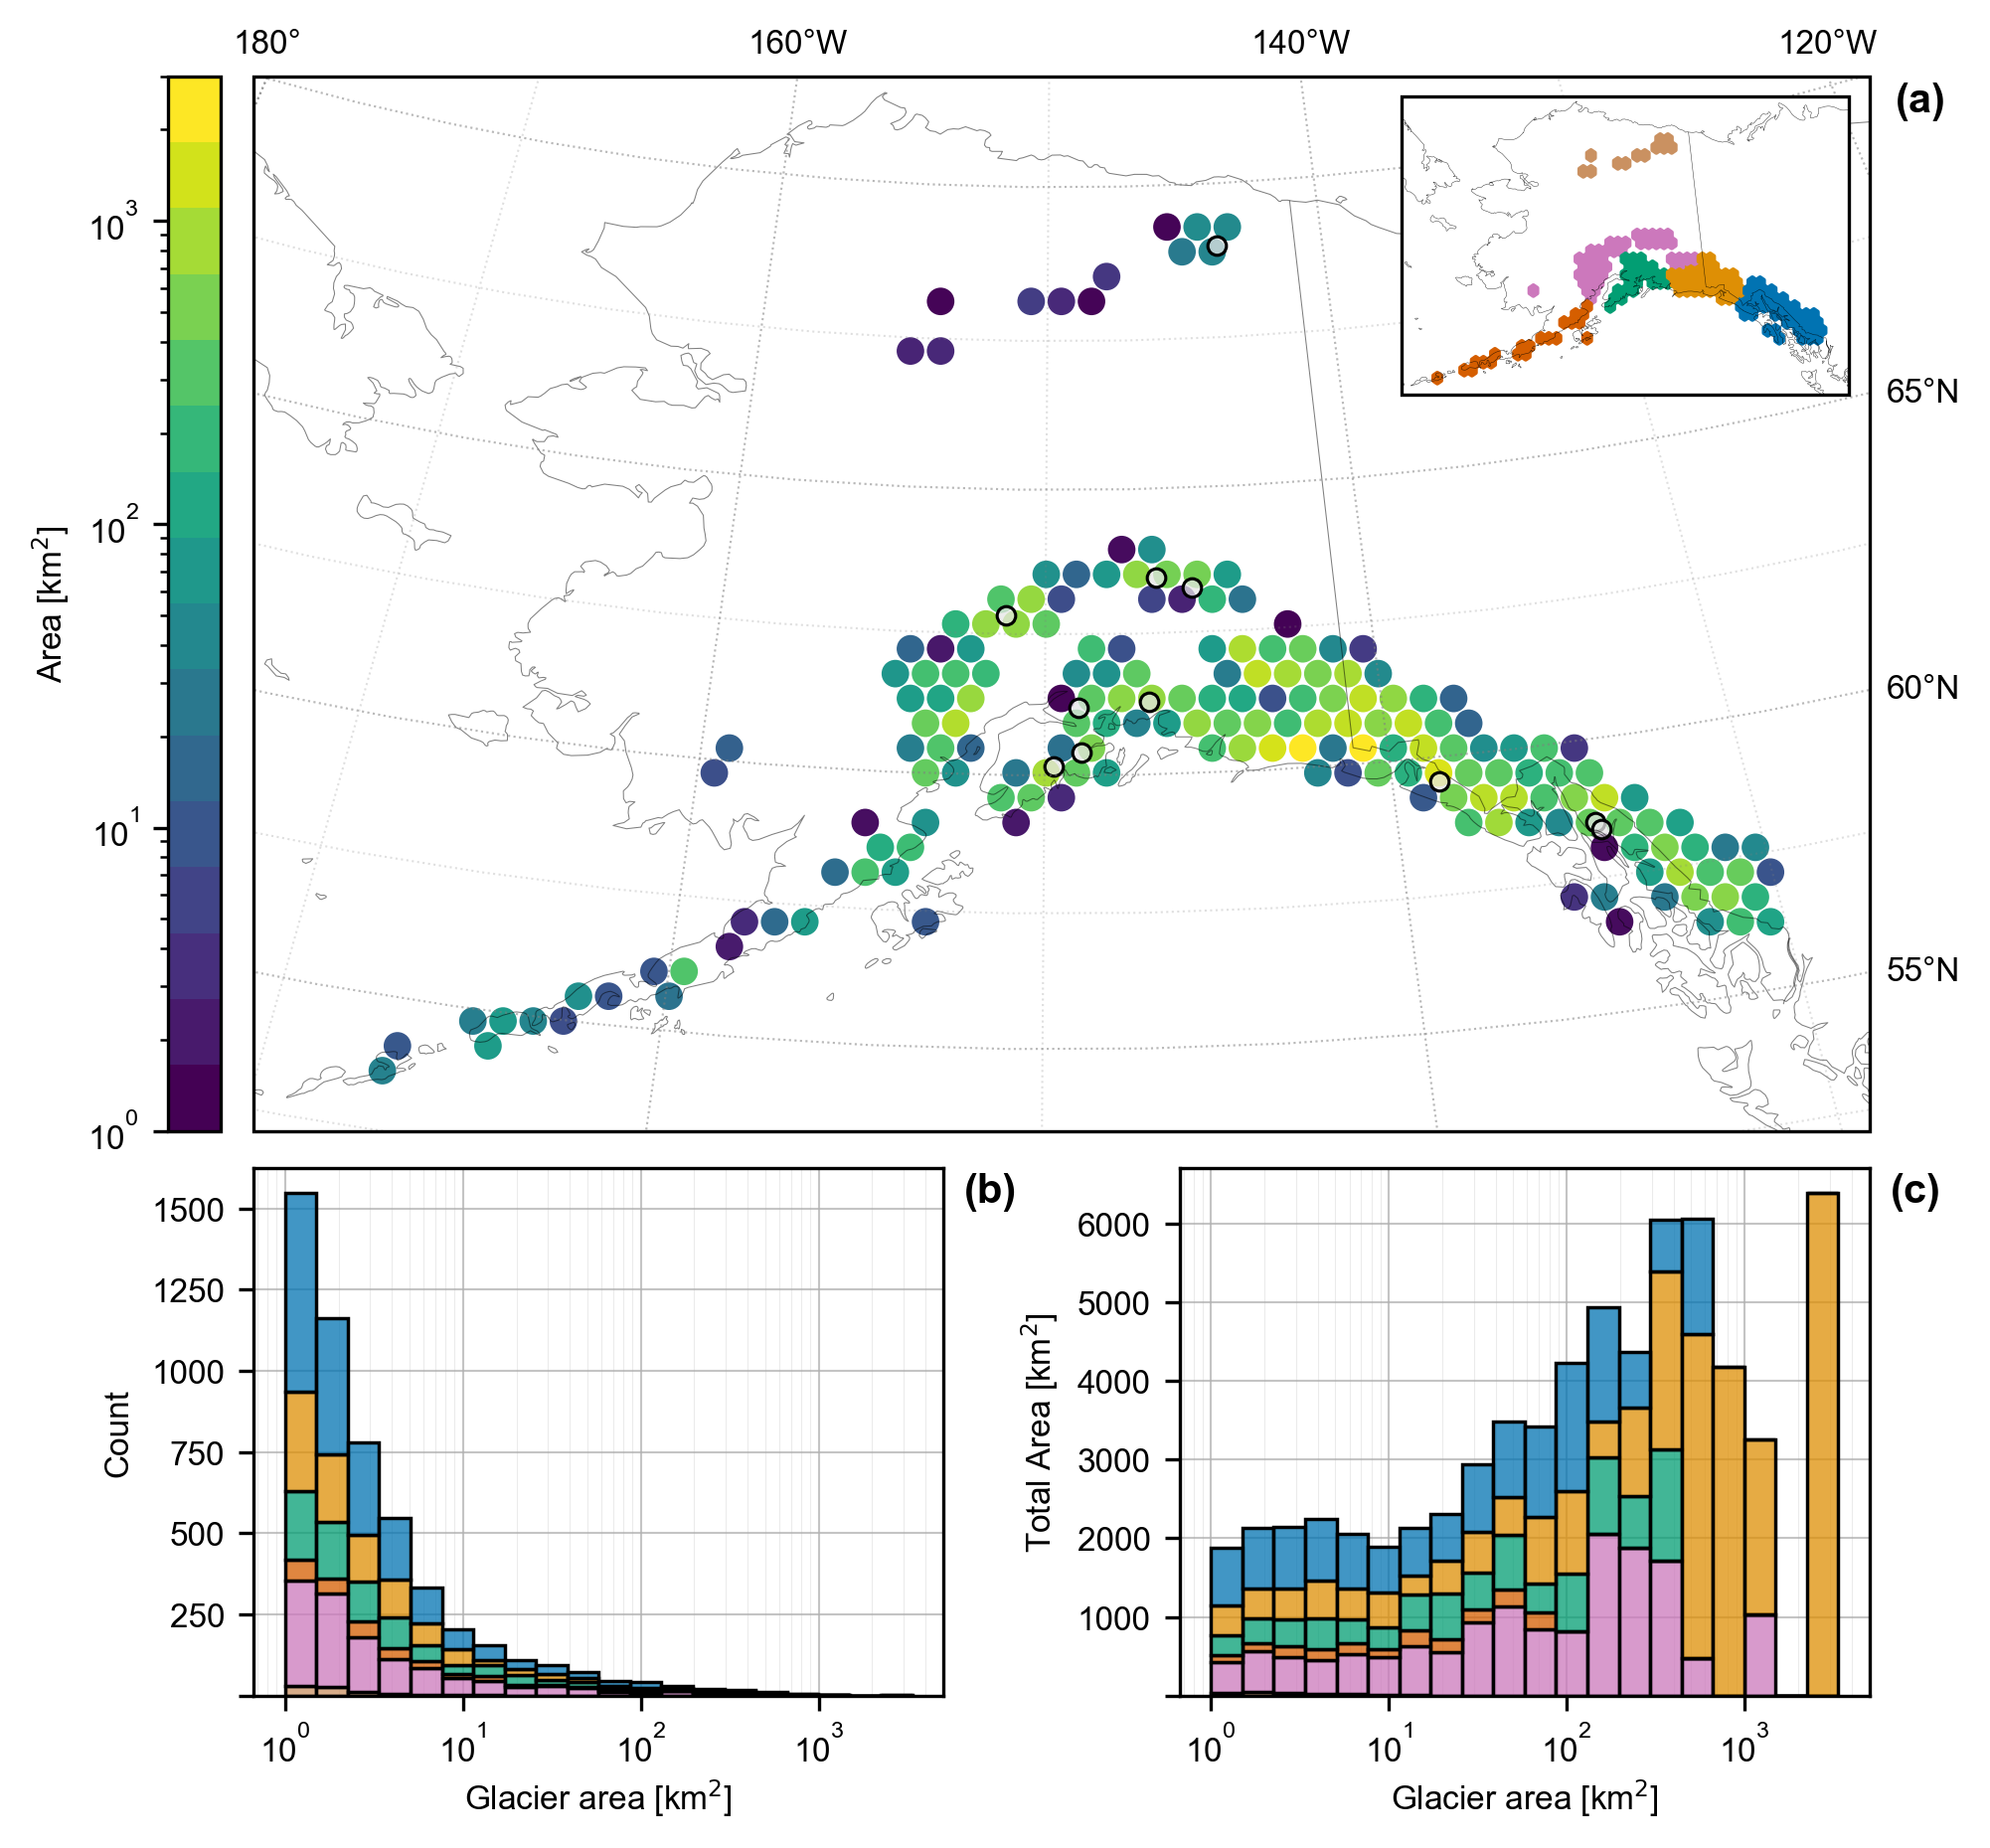

In [9]:
XSMALL_SIZE = 8
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # contr
plt.rc('font', family="sans-serif")          # controls default font face
plt.rcParams["font.sans-serif"] = ['Arial']
plt.rc('axes', titlesize=XSMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=XSMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


plt.rc("figure.constrained_layout", w_pad=0)
plt.rc("figure.constrained_layout", h_pad=0)

lonW = -170
lonE = -129
latS = 53
latN = 71
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '50m'

fig = plt.figure(layout='compressed', figsize=(6.5, 6), dpi=300)
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=(1, 1, 1), figure=fig, hspace=0.02, wspace=0)
mapax = fig.add_subplot(gs[0:2, :], projection=ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat))
ax = np.empty(2, dtype='object')
ax[0] = fig.add_subplot(gs[2, 0])
ax[1] = fig.add_subplot(gs[2, 1])

######################
# Map
######################
mapax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
mapax.set_aspect('auto', adjustable=None)
coast = cfeature.NaturalEarthFeature(
    category='physical',
    name='coastline',
    scale=res,
    facecolor='none')
borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale=res,
    facecolor='none')
mapax.add_feature(borders, linewidth=0.25, edgecolor='black', alpha=0.5)
mapax.add_feature(coast, linewidth=0.25, edgecolor='black', alpha=0.5)

hex = mapax.hexbin(
    d.CenLon,
    d.CenLat,
    C=d.Area,
    #gridsize=(50, 15),
    gridsize=(46, 17),
    bins='log',
    transform=ccrs.PlateCarree(),
    reduce_C_function=np.sum,
    visible=False,
)
offsets = hex.get_offsets()
values = hex.get_array()
vmin, vmax = values.min(), values.max()
vmax = 3e3
vmin = 1
cmap = mpl.colors.ListedColormap(plt.cm.viridis(np.linspace(0,1,256)))
scat = mapax.scatter(
    offsets[:,0],
    offsets[:,1],
    c=values,
    norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
    s=32,
    marker="o",
    cmap=cmap,
)


colors = cmap(np.linspace(0, 1, 16))
discrete_cmap = mpl.colors.ListedColormap(colors)
sm = mpl.cm.ScalarMappable(mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=discrete_cmap)
cb = plt.colorbar(
    sm,
    ax=mapax,
    location='left',
    use_gridspec=True,
    shrink=1.0,
    pad=-0.0725,
    fraction=0.05,
)
cb.ax.tick_params(labelsize=XSMALL_SIZE)
cb.ax.set_ylabel('Area [km$^2$]',fontsize=XSMALL_SIZE)

# mass balance points
mapax.scatter(
    mb_locs['CenLon'],
    mb_locs['CenLat'],
    facecolor=(0.9,0.9,0.9, 0.75),
    edgecolor=(0,0,0,1),
    marker='o',
    lw=0.75,
    s=20,
    transform=ccrs.PlateCarree(),
)

# gridlines
label_style = {'rotation': 0, 'fontsize': XSMALL_SIZE}
gl_maj = mapax.gridlines(
    draw_labels=['top', 'right'], linewidth=0.5, color='grey',
    alpha=0.4,
    linestyle=':',
    xlocs=mpl.ticker.MultipleLocator(20),
    ylocs=mpl.ticker.MultipleLocator(5),
    x_inline=False, y_inline=False,
    xlabel_style=label_style,
    ylabel_style=label_style,
    xpadding=4,
    ypadding=4,
    rotate_labels=False
)
gl_min = mapax.gridlines(
    draw_labels=False,
    linewidth=0.5,
    color='grey',
    alpha=0.25,
    linestyle=':',
    xlocs=mpl.ticker.MultipleLocator(10),
    ylocs=None,
)


##############
# Bottom 
##############
cmap = plt.colormaps['tab10']
sns.histplot(
    d,
    x='Area',
    hue='O2Region',
    hue_order=['6', '5', '4', '3', '2', '1'],
    #weights='Area',
    ax=ax[0],
    legend=False,
    log_scale=True,
    stat='count',
    multiple='stack',
    palette='colorblind',
    bins=20,
)
sns.histplot(
    d,
    x='Area',
    hue='O2Region',
    hue_order=['6', '5', '4', '3', '2', '1'],
    weights='Area',
    ax=ax[1],
    legend=False,
    log_scale=True,
    stat='count',
    multiple='stack',
    palette='colorblind',
    bins=20,
)

# Main plot formatting
for axis in ax.ravel():
    axis.set_axisbelow(True)
    #axis.set_xlim(0, 4500)
    axis.grid(True, which='minor', axis='both', lw=0.25, alpha=0.25)
    axis.grid(True, which='major', axis='both', lw=0.5, alpha=0.75)
    axis.tick_params(axis="both", which='both', direction="out", left=False, bottom=False, labelbottom=False)
    axis.tick_params(axis='both', which='major', labelsize=XSMALL_SIZE, left=True, bottom=True, labelbottom=True)
    axis.tick_params(axis='x', which='major', direction='out')
    axis.set_xlabel('')
    # get around the disappearing ticks???
    # https://stackoverflow.com/questions/40311175/matplotlib-strange-double-decade-axis-ticks-in-log-plot?rq=1
    axis.xaxis.set_major_locator(mpl.ticker.LogLocator(numticks=15)) #(1)
    axis.xaxis.set_minor_locator(mpl.ticker.LogLocator(numticks=15,subs=np.arange(2,10))) #(2)

ax[0].set_ylabel('Count', fontsize=XSMALL_SIZE)
ax[0].set_xlabel('Glacier area [km$^2$]', fontsize=XSMALL_SIZE, labelpad=2)

ax[1].set_xlabel('Glacier area [km$^2$]', fontsize=XSMALL_SIZE, labelpad=2)
ax[1].set_ylabel('Total Area [km$^2$]',fontsize=XSMALL_SIZE,)  # todo: Area per bin?
#plt.setp(ax[1].get_yticklabels(), visible=False)  # for gridspec weirdness


########################
# inset axis!
########################
inset = inset_axes(mapax, width=1.5, height=1, loc=1, axes_class=cartopy.mpl.geoaxes.GeoAxes, axes_kwargs={"projection":ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)})
inset.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
inset.set_aspect('auto', adjustable=None)
coast = cfeature.NaturalEarthFeature(
    category='physical',
    name='coastline',
    scale=res,
    facecolor='none')
borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale=res,
    facecolor='none')
inset.add_feature(borders, linewidth=0.125, edgecolor='black', alpha=0.75)
inset.add_feature(coast, linewidth=0.125, edgecolor='black', alpha=0.75)
tab10 = mpl.colors.ListedColormap(sns.color_palette('colorblind', as_cmap=True))
print(type(tab10))
print(tab10)
colors = tab10(np.arange(0.5, -0.1, -0.1))
cmap = mpl.colors.LinearSegmentedColormap.from_list('tab6', colors)
hex = inset.hexbin(
    d.CenLon,
    d.CenLat,
    C=d.O2Region.astype('float'),
    gridsize=(50, 15),
    transform=ccrs.PlateCarree(),
    reduce_C_function=np.median,
    visible=True,
    cmap=cmap
)
inset.set_aspect('auto')

# Important to render initial ytick labels
fig.canvas.draw()

# remove bottom ylabel
for axis in ax:
    labels = [item for item in axis.get_yticklabels()]
    labels[0].set_text('')
    print(labels)
    axis.set_yticklabels(labels)

###################
# subplot labels
###################
# B C labels
sp_labels = ['(' + letter + ')' for letter in string.ascii_lowercase]
for i, axis in enumerate(ax):
    i = i + 1  # mapax is 0
    # label physical distance in and down:
    trans = mpl.transforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    #axis.text(0.975, 1.2, sp_labels[i], transform=axis.transAxes + trans,
    axis.text(0.97, 1.0325, sp_labels[i], transform=axis.transAxes + trans,
              verticalalignment='top', fontsize=SMALL_SIZE, fontweight='bold', va='top')
# A label
mapax.text(0.99, 1.015, sp_labels[0], transform=mapax.transAxes + trans,
          verticalalignment='top', fontsize=SMALL_SIZE, fontweight='bold', va='top')


plt.savefig(Path('Fig2.pdf'),bbox_inches='tight')
plt.savefig(Path('Fig2.svg'),bbox_inches='tight')
plt.savefig(Path('Fig2.png'),bbox_inches='tight')
